In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'bitcoin:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4602406%2F7848684%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240412%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240412T171410Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8acdc95225fdc899956ba4e4d8271be94935869a2ba5029efbfc283c94877277c4739b6d55028cee49541165b580348f59cee0b9f9eabbd29e49988a6b0f3a93cddb4d518cbc7bab397b759b070c3408d43a9a9b91aa97aca5336ad5cceb402b758ff98066212c5e01171f6eda6cf707ada63ff1a54eded62186bd5ce10803f2f607fb8f684d2add2bca6191cb0bb7447a20aa077674b51e6367794c84d20ad042f307cf24a8b3823b41e7f932c5a9438e27fd6f5028d06574f66a3ec9b3ab8b9ba7b8006a7115195456a012b10b7e27c704c5abdc6d97c025b620c011a20cedbde77f10dff9b9e2581f59010141571a4654245afe39208abc6dc4a9c2982c7c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 856611 bytes downloaded
Downloaded and uncompressed: bitcoin
Data source import complete.


Installing Required Libraries

In [ ]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=7b78eab1f948970547fe052649ae9810b266f54903ad215d14d0d2f683c48d20
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [ ]:
!pip install yfinance

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta

Importing dataset and preprocessing

In [ ]:
data = pd.read_csv('/kaggle/input/bitcoin/btcusdt_1h.csv')
data.dropna(inplace=True)
data.reset_index(inplace = True)
data.drop(['datetime'], axis=1, inplace=True)

In [ ]:
data

,index,open,high,low,close,volume
0,0,13715.65,13715.65,13400.01,13529.01,443.356199
1,1,13528.99,13595.89,13155.38,13203.06,383.697006
2,2,13203.00,13418.43,13200.00,13330.18,429.064572
3,3,13330.26,13611.27,13290.00,13410.03,420.087030
4,4,13434.98,13623.29,13322.15,13601.01,340.807329
...,...,...,...,...,...,...
35203,35203,42972.04,43095.26,42692.19,42800.38,1219.601780
35204,35204,42797.62,42823.69,42643.74,42659.20,702.103800
35205,35205,42664.71,42776.14,42597.41,42713.13,561.859930
35206,35206,42713.12,42886.28,42633.97,42729.29,681.142010


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler


# Extract features (all columns except the last one)
features = data.iloc[:, 1:]

# Standardize each feature column by column
scaler = StandardScaler()
standardized_features = scaler.fit_transform(features)

# Replace the original feature columns with standardized ones
for i, column in enumerate(features.columns):
    if(column!='datetime'):
        data[column] = standardized_features[:, i]

# Now, data contains standardized features
print(data.head())


   index      open      high       low     close    volume
0      0 -0.270629 -0.275122 -0.283534 -0.281139 -0.839447
1      1 -0.281101 -0.281801 -0.297347 -0.299426 -0.866711
2      2 -0.299390 -0.291697 -0.294828 -0.292294 -0.845979
3      3 -0.292251 -0.280943 -0.289746 -0.287814 -0.850081
4      4 -0.286376 -0.280273 -0.287930 -0.277100 -0.886311


Making Custom Dataset

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data.values
        self.features = self.data[:, :-1].astype(np.float32)  # All columns except the last one
        self.targets = self.data[:, -1].astype(np.float32)     # Last column is the target (volume)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]


In [ ]:
from sklearn.model_selection import train_test_split
# csv_file_path = 'btcusdt_1h.csv'
dataset = CustomDataset(data)

# Splitting dataset into train and validation sets
train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)

# Creating train and validation datasets
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

# Creating train and validation data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


Custom Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

import torch.nn.functional as F

# Define the VolumePredictor model
class VolumePredictor(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_prob=0.5):
        super(VolumePredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x



In [ ]:
# # Assuming df is your DataFrame with the financial data
# # Drop 'datetime' column and split the data into features and target
# features = df.drop(['datetime', 'volume'], axis=1).values.astype(float)
# target = df['volume'].values.astype(float)

# # Standardize features
# scaler = StandardScaler()
# features = scaler.fit_transform(features)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# # Convert to PyTorch tensors
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
# X_val_tensor = torch.tensor(X_test, dtype=torch.float32)
# y_val_tensor = torch.tensor(y_test, dtype=torch.float32)

# # Create DataLoader
# train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
# train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)



In [ ]:
# # Training loop
# num_epochs = 500
# train_losses = []
# val_losses = []

# for epoch in range(num_epochs):
#     # Training
#     model.train()
#     train_loss = 0.0
#     for batch_features, batch_targets in train_loader:
#         optimizer.zero_grad()
#         outputs = model(batch_features)
#         loss = criterion(outputs, batch_targets)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item() * batch_features.size(0)
#     train_loss /= len(train_loader.dataset)
#     train_losses.append(train_loss)

#     # Validation
#     model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for batch_features, batch_targets in val_loader:
#             outputs = model(batch_features)
#             loss = criterion(outputs, batch_targets)
#             val_loss += loss.item() * batch_features.size(0)
#         val_loss /= len(val_loader.dataset)
#         val_losses.append(val_loss)

#     print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

In [ ]:


# # Splitting dataset into train and validation sets
# X_train, X_val, y_train, y_val = train_test_split(standardized_features, data.iloc[:, -1].values, test_size=0.2, random_state=42)

# # Convert numpy arrays to tensors
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
# X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
# y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# # Create DataLoader for training and validation sets
# train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
# val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

Inverse Scaler to scale back to original values

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Inverse transform function
def inverse_transform(predictions, scaler):
    return scaler.inverse_transform(predictions)

# # MinMaxScaler for the target variable y
# y_scaler = MinMaxScaler(feature_range=(0, 1))
# # y_test = np.reshape(yi, (len(yi), 1))  # Reshape yi if needed
# y_scaled = y_scaler.fit_transform(y_test)

def inv_tr(df):
  df = df*(max(data['close'])-min(data['close'])) + min(data['close'])
  return df

In [ ]:
def max_profit_infinite_transactions(opening, closing):
  """
  Calculates the maximum achievable profit with infinite transactions in a stock price series.

  Args:
    opening: An array of opening prices for each day.
    closing: An array of closing prices for each day, corresponding to opening prices.

  Returns:
    The maximum achievable profit considering all possible transactions.
  """
  profit = [0] * len(opening)

  for i in range(1, len(opening)):
    diff = closing[i] - opening[i]
    if diff > 0:
      # Hold + profit from previous day
      profit[i] = profit[i-1] + diff
    else:
      # Max of holding or selling and starting fresh
      profit[i] = max(profit[i-1], opening[i])

  return profit[-1]


In [ ]:
data=pd.read_csv('/kaggle/input/bitcoin/btcusdt_1h.csv')

Adding additional Indicators

In [ ]:
# Adding indicators
data['RSI']=ta.rsi(data.close, length=15)
data['EMAF']=ta.ema(data.close, length=20)
data['EMAM']=ta.ema(data.close, length=100)
data['EMAS']=ta.ema(data.close, length=150)

data['Target'] = data['close']-data.open
data['Target'] = data['Target'].shift(-1)

data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]

data['TargetNextClose'] = data['close'].shift(-1)

data.dropna(inplace=True)
data.reset_index(inplace = True)
data.drop(['datetime'], axis=1, inplace=True)

In [ ]:
data

,index,open,high,low,close,volume,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
0,149,16564.00,16683.44,16400.00,16417.05,721.569884,44.224762,16674.010636,15686.961719,14963.625400,328.99,1,16746.99
1,150,16418.00,16749.98,16409.71,16746.99,577.845180,53.801147,16680.961051,15707.952378,14987.246123,-27.98,0,16719.02
2,151,16747.00,16886.75,16695.66,16719.02,640.796589,52.975010,16684.585713,15727.973519,15010.183526,-28.95,0,16690.06
3,152,16719.01,16800.00,16579.33,16690.06,443.503664,52.087721,16685.107074,15747.024736,15032.433545,48.94,1,16739.00
4,153,16690.06,16814.72,16633.16,16739.00,215.643791,53.497966,16690.239733,15766.667811,15055.037074,-131.99,0,16607.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35053,35202,42754.99,43086.70,42595.68,42972.05,1440.445690,65.239213,42128.925673,42199.684279,42696.032562,-171.66,0,42800.38
35054,35203,42972.04,43095.26,42692.19,42800.38,1219.601780,61.782569,42192.873704,42211.579244,42697.414647,-138.42,0,42659.20
35055,35204,42797.62,42823.69,42643.74,42659.20,702.103800,59.026834,42237.285732,42220.443021,42696.908493,48.42,1,42713.13
35056,35205,42664.71,42776.14,42597.41,42713.13,561.859930,59.761407,42282.604234,42230.199199,42697.123347,16.17,1,42729.29


In [ ]:
data['v']=data['volume']
data.drop(columns=['volume'],inplace=True)
# data['volume']=data['v']

In [ ]:
data

,index,open,high,low,close,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose,v
0,149,16564.00,16683.44,16400.00,16417.05,44.224762,16674.010636,15686.961719,14963.625400,328.99,1,16746.99,721.569884
1,150,16418.00,16749.98,16409.71,16746.99,53.801147,16680.961051,15707.952378,14987.246123,-27.98,0,16719.02,577.845180
2,151,16747.00,16886.75,16695.66,16719.02,52.975010,16684.585713,15727.973519,15010.183526,-28.95,0,16690.06,640.796589
3,152,16719.01,16800.00,16579.33,16690.06,52.087721,16685.107074,15747.024736,15032.433545,48.94,1,16739.00,443.503664
4,153,16690.06,16814.72,16633.16,16739.00,53.497966,16690.239733,15766.667811,15055.037074,-131.99,0,16607.00,215.643791
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35053,35202,42754.99,43086.70,42595.68,42972.05,65.239213,42128.925673,42199.684279,42696.032562,-171.66,0,42800.38,1440.445690
35054,35203,42972.04,43095.26,42692.19,42800.38,61.782569,42192.873704,42211.579244,42697.414647,-138.42,0,42659.20,1219.601780
35055,35204,42797.62,42823.69,42643.74,42659.20,59.026834,42237.285732,42220.443021,42696.908493,48.42,1,42713.13,702.103800
35056,35205,42664.71,42776.14,42597.41,42713.13,59.761407,42282.604234,42230.199199,42697.123347,16.17,1,42729.29,561.859930


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler


# Extract features (all columns except the last one)
features = data.iloc[:, 1:]

# Standardize each feature column by column
scaler = StandardScaler()
standardized_features = scaler.fit_transform(features)

# Replace the original feature columns with standardized ones
for i, column in enumerate(features.columns):
    if(column!='datetime'):
        data[column] = standardized_features[:, i]

# Now, data contains standardized features
print(data.head())


   index      open      high       low     close       RSI      EMAF  \
0    149 -0.111424 -0.110198 -0.114740 -0.119690 -0.551454 -0.104976   
1    150 -0.119599 -0.106495 -0.114193 -0.101217  0.247168 -0.104586   
2    151 -0.101178 -0.098883 -0.098079 -0.102783  0.178273 -0.104383   
3    152 -0.102745 -0.103711 -0.104634 -0.104405  0.104277 -0.104354   
4    153 -0.104366 -0.102892 -0.101601 -0.101664  0.221885 -0.104066   

       EMAM      EMAS    Target  TargetClass  TargetNextClose         v  
0 -0.158923 -0.198637  1.515291     0.980396        -0.101256 -0.714533  
1 -0.157745 -0.197309 -0.132600    -1.019996        -0.102822 -0.780144  
2 -0.156620 -0.196019 -0.137078    -1.019996        -0.104444 -0.751407  
3 -0.155551 -0.194768  0.222488     0.980396        -0.101704 -0.841472  
4 -0.154448 -0.193496 -0.612744    -1.019996        -0.109094 -0.945492  


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data.values
        self.features = self.data[:, :-1].astype(np.float32)  # All columns except the last one
        self.targets = self.data[:, -1].astype(np.float32)     # Last column is the target (volume)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]


In [ ]:
# csv_file_path = 'btcusdt_1h.csv'
dataset = CustomDataset(data)

# Splitting dataset into train and validation sets
train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)

# Creating train and validation datasets
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

# Creating train and validation data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model, loss function, and optimizer
model = VolumePredictor(input_size=12,hidden_size1= 64,hidden_size2=32, output_size=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


model

VolumePredictor(
  (fc1): Linear(in_features=12, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
# Training loop
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for batch_features, batch_targets in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_features.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_features, batch_targets in val_loader:
            outputs = model(batch_features)
            loss = criterion(outputs, batch_targets)
            val_loss += loss.item() * batch_features.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

    if((epoch+1)%10==0):
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Epoch 10/100, Train Loss: 0.9639, Val Loss: 1.1453
Epoch 20/100, Train Loss: 0.9638, Val Loss: 1.1453
Epoch 30/100, Train Loss: 0.9647, Val Loss: 1.1454
Epoch 40/100, Train Loss: 0.9644, Val Loss: 1.1457
Epoch 50/100, Train Loss: 0.9639, Val Loss: 1.1456
Epoch 60/100, Train Loss: 0.9637, Val Loss: 1.1454
Epoch 70/100, Train Loss: 0.9637, Val Loss: 1.1453
Epoch 80/100, Train Loss: 0.9637, Val Loss: 1.1457
Epoch 90/100, Train Loss: 0.9637, Val Loss: 1.1455
Epoch 100/100, Train Loss: 0.9638, Val Loss: 1.1454


In [ ]:
# Lists to store predicted values
y_pred_list = []

# Lists to store original y_test values
y_test_list = []

# Validation
with torch.no_grad():
    for inputs, targets in val_loader:

        outputs = model(inputs)
        y_pred_list.append(outputs.cpu().numpy())  # Append predictions to the list
#         print(outputs,inputs)
        y_test_list.append(targets.cpu().numpy())  # Append original targets to the list

# Concatenate all original targets into a single array
y_test = np.concatenate(y_test_list)

# Validation
# model.eval()


# Concatenate all predictions into a single array
y_pred = np.concatenate(y_pred_list)
y_pred

array([[-0.00121622],
       [-0.00121622],
       [-0.00121622],
       ...,
       [-0.00121622],
       [-0.00121622],
       [-0.00121622]], dtype=float32)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Inverse transform function
def inverse_transform(predictions, scaler):
    return scaler.inverse_transform(predictions)

# # MinMaxScaler for the target variable y
# y_scaler = MinMaxScaler(feature_range=(0, 1))
# # y_test = np.reshape(yi, (len(yi), 1))  # Reshape yi if needed
# y_scaled = y_scaler.fit_transform(y_test)

def inv_tr(df):
  df = df*(max(data['close'])-min(data['close'])) + min(data['close'])
  return df

In [ ]:
#  Inverse transform the predictions back to the original scale
y_pred_original_scale = inv_tr(y_pred)

# Inverse transform the true values back to the original scale
y_test_original_scale = inv_tr(y_test)

# Print the first 10 samples of predictions and true values in the original scale
for i in range(10):
    print(y_pred_original_scale[i], y_test_original_scale[i])

[-0.8657231] -1.8591557
[-0.8657231] 0.8332885
[-0.8657231] -1.9986229
[-0.8657231] -2.937174
[-0.8657231] -2.6465862
[-0.8657231] -0.7494392
[-0.8657231] -3.847262
[-0.8657231] -1.4799926
[-0.8657231] -1.3424149
[-0.8657231] -1.2468154


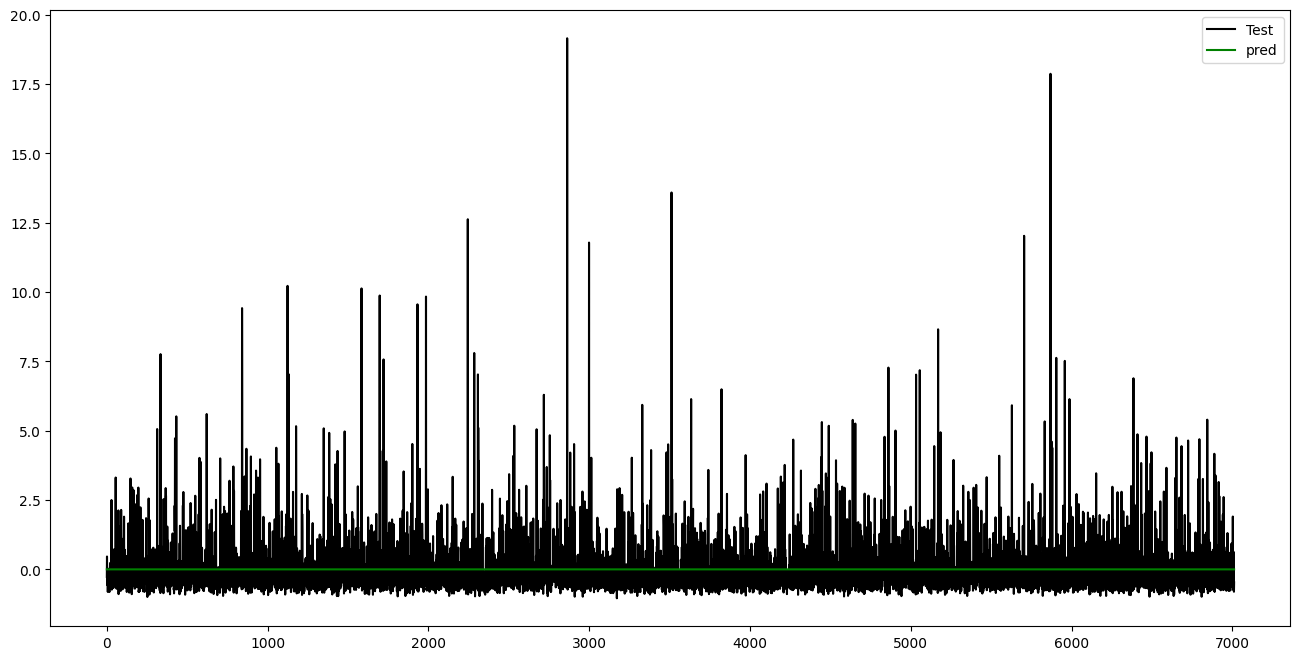

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()